basado en el post:
https://stackoverflow.com/questions/19986198/emulate-photoshops-color-range-algorithm

In [1]:
#backend matplotlib notebook para uso de eventos del mouse 
%matplotlib notebook

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys

#Scripts para leer y procesar imagen
sys.path.insert(0, '../Golden Master (AS IS)')
import readImage
import preProcessing as pP
import sorts as srt
import perspective as pPe
import indAnalysis as inA
import writeImage2

Im happy...


In [3]:
#para probar en caso de que no se identifique correctamente el backend
#print("***** TESTING WITH BACKEND: %s"%matplotlib.get_backend() + " *****")

In [4]:
#callback para clck del mouse
coords = []
event_data = []
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    #print 'x = %d, y = %d'%(ix, iy)

    global coords
    global event_data
    if not (ix,iy) in coords:
        coords.append((ix, iy))
        event_data.append(event)

    #if len(coords) == 2:
    #    fig.canvas.mpl_disconnect(cid)

    return coords

In [5]:
#leer una imagen de prueba
batch = False
qr = '601170500100157'
qr_count = 1

<IPython.core.display.Javascript object>


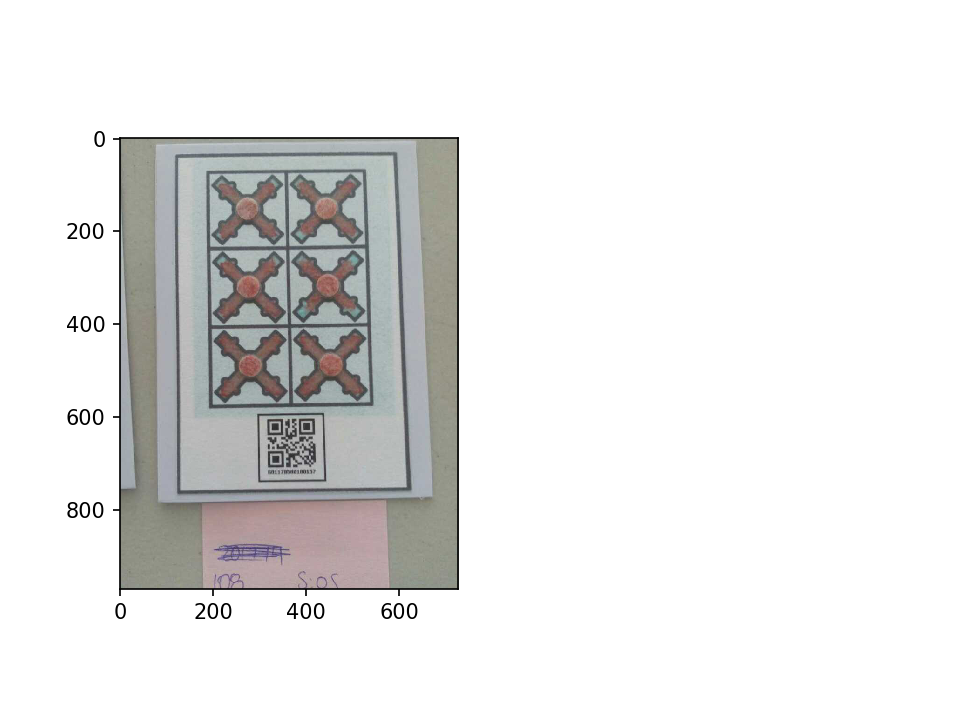

In [6]:
#Read from local file local = True, from db local = False, count = Test repeated
imgBGR = readImage.readImage(qr, local = False, count = qr_count)
if(isinstance(imgBGR, str)):
    print(imgBGR)
else: 
    # show the original image
    if (not batch):
     plt.subplot(121),plt.imshow(cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB))
     plt.show()

In [7]:
imgBGR.shape

(970L, 728L, 3L)

<IPython.core.display.Javascript object>


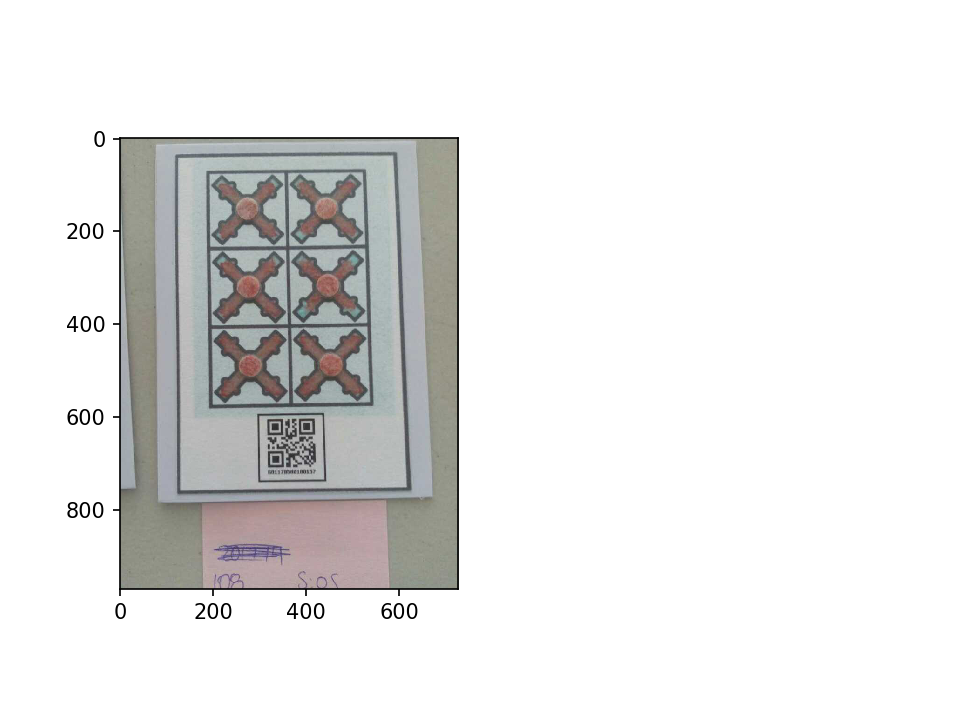

In [8]:
#registrar callback 
fig = plt.gcf()
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()
fig

In [9]:
coords

[(499.96634782360445, 527.30485887096768),
 (493.50828330747538, 443.35002016129033),
 (457.98892846876572, 485.32743951612906),
 (406.3244123397335, 436.89195564516126)]

In [10]:
#mouse cordinates correspond to image pixels: y to rows, x to columns
#for example:
#       image shape (970L, 728L, 3L)
#       mouse coordinates   (725,968)
#       numpy indexes (968,725)
selected_pixels = [ imgBGR[int(x[1]),int(x[0])].astype(int) for x in coords if not x[0] == None and not x[1] == None ]
selected_pixels

[array([ 89,  99, 129]),
 array([ 87, 102, 135]),
 array([ 91,  98, 155]),
 array([ 92, 102, 126])]

In [11]:
#get mean of selected pixels cluster
selected_color_cluster_mean = sum(selected_pixels) / len(selected_pixels)
selected_color_cluster_mean

array([ 89, 100, 136])

In [12]:
#calculate euclidean distance between selected pixels cluster and rest of the images in RGB space
sqrdistance = pow(imgBGR - selected_color_cluster_mean,2)
sqrdistance.shape
#sqrdistance 

(970L, 728L, 3L)

<IPython.core.display.Javascript object>


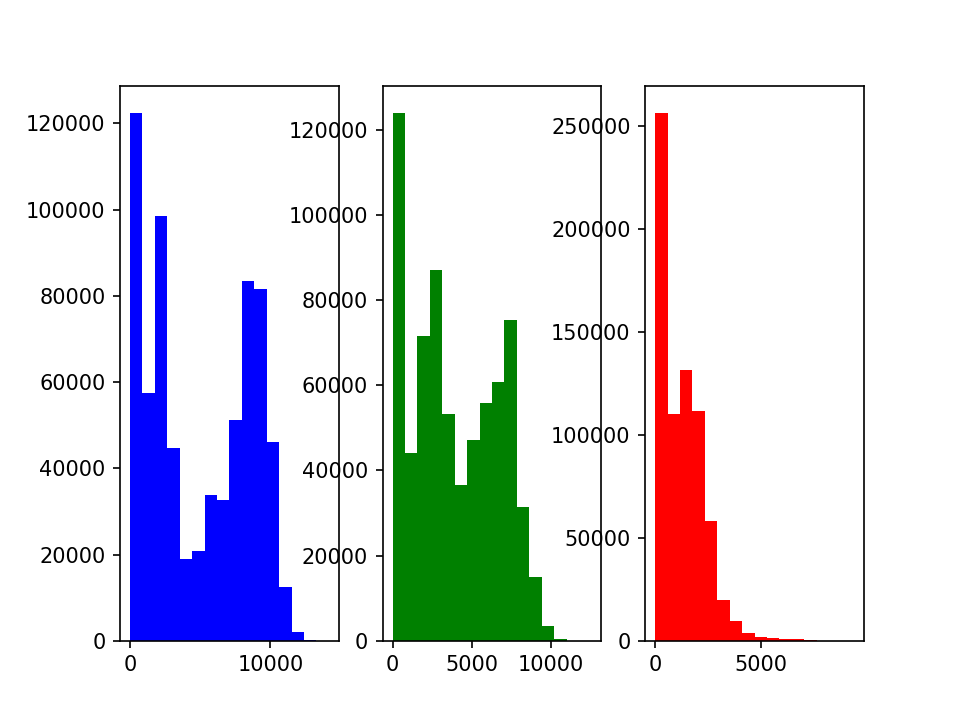

In [13]:
plt.clf()
plt.close()
b,g,r = cv2.split(sqrdistance)
plt.subplot(131),  
plt.hist(b.flatten(), bins = 16, color = ['blue'])  
plt.subplot(132),  
plt.hist(g.flatten(), bins = 16, color = ['green'])
plt.subplot(133),  
plt.hist(r.flatten(), bins = 16, color = ['red'])
plt.show()

In [14]:
sqrdist = sqrdistance.sum(axis = 2)

In [15]:
#normalize (min to 0, max to 1)
from __future__ import division
ndist = (sqrdist - np.amin(sqrdist)) / (np.amax(sqrdist) - np.amin(sqrdist))
ndist[0,0]

0.16701124176250162

In [16]:
#apply falloff function, e.g. Gaussian 
def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

In [17]:
fdist = gaussian(ndist, 0, 1/3)
fdist[0,0]

0.88204041949129597

<IPython.core.display.Javascript object>


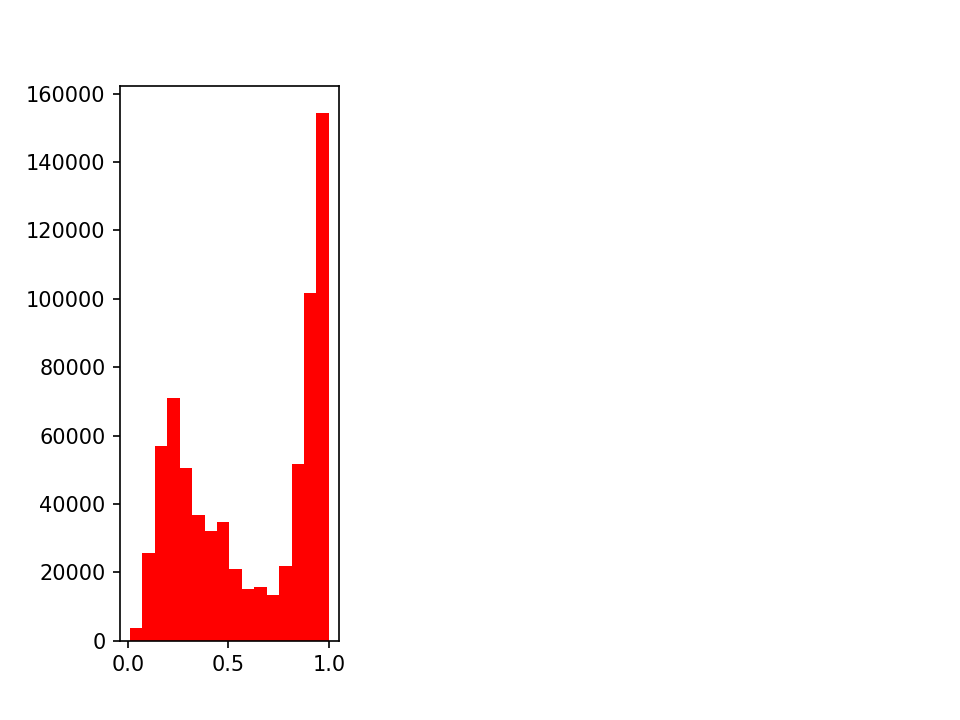

In [18]:
plt.clf()
plt.close()
plt.subplot(131),  
plt.hist(fdist.flatten(), bins = 16, color = ['red'])  
plt.show()

In [ ]:
#choose a threshold value of falloff function above which you will select the given pixel

In [21]:
thres = 0.995
sel_thres = fdist > thres
sel_thres.shape

(970L, 728L)

<IPython.core.display.Javascript object>


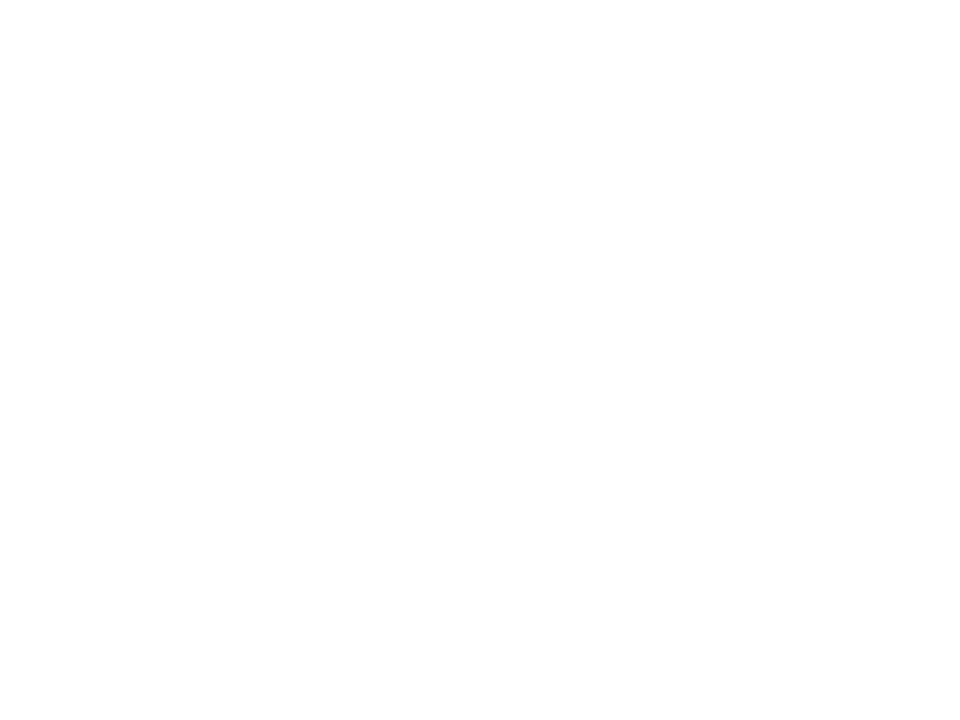

<IPython.core.display.Javascript object>


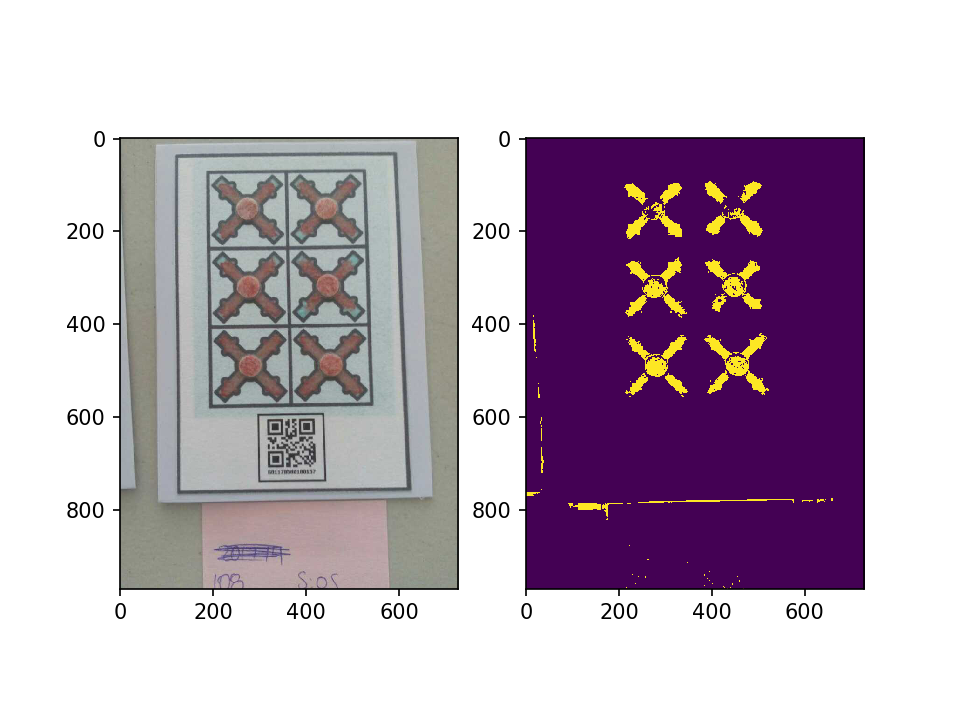

In [22]:
plt.clf()
plt.close()
plt.subplot(121),plt.imshow(cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB))
plt.subplot(122),plt.imshow(sel_thres)
plt.show()